In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV  
from sklearn.model_selection import RandomizedSearchCV
import shutil
import os
import zipfile

##### Unzip data files with indicators

In [2]:
script_dir = os.getcwd()

In [3]:
# Function to extract ZIP files directly into the same directory (without subfolders)
def extract_zip_files(script_dir):
    output_dir = os.path.join(script_dir, "data_with_indicators")

    for file in os.listdir(output_dir):
        if file.endswith(".zip"):
            zip_path = os.path.join(output_dir, file)
            extracted_file_name = file.replace(".zip", ".csv")
            extracted_file_path = os.path.join(output_dir, extracted_file_name)

            # Only extract if the CSV file does not exist
            if not os.path.exists(extracted_file_path):
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(output_dir)
                print(f"Extracted: {zip_path} → {extracted_file_path}")
            else:
                print(f"Skipping extraction (already exists): {extracted_file_path}")


In [4]:
extract_zip_files(script_dir)

Skipping extraction (already exists): /Users/linyan/Desktop/4211-project/crypto/copy/data_with_indicators/crypto_prices_30m_with_indicators.csv
Skipping extraction (already exists): /Users/linyan/Desktop/4211-project/crypto/copy/data_with_indicators/crypto_prices_5m_with_indicators.csv
Skipping extraction (already exists): /Users/linyan/Desktop/4211-project/crypto/copy/data_with_indicators/crypto_prices_1h_with_indicators.csv
Skipping extraction (already exists): /Users/linyan/Desktop/4211-project/crypto/copy/data_with_indicators/crypto_prices_1m_with_indicators.csv


#### 1. Run on 1-minute data

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism() 


#Code for Hyperparameter Tuning
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['Datetime'] = df['Date']
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.sort_values(['Coin', 'Datetime'], inplace=True)
  
    df['Return'] = df.groupby('Coin')['Close'].pct_change().shift(-1)  # Next period return as target
    non_features = ['Datetime', 'Coin', 'Date', 'Return']
    feature_cols = [x for x in list(df.columns) if x not in non_features]
    df = df[feature_cols + non_features].dropna()
    df.dropna(inplace=True)
    
    return df, feature_cols

# Prepare sequences for LSTM training
def prepare_sequences(df, feature_cols, sequence_length=20):
    #feature_scaler = RobustScaler()
    #return_scaler = RobustScaler()
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    return_scaler = MinMaxScaler(feature_range=(0, 1))
    
    X_scaled = feature_scaler.fit_transform(df[feature_cols])
    y_scaled = return_scaler.fit_transform(df[['Return']])
    
    X_sequences, y_sequences, dates, close_prices = [], [], df['Datetime'].values[sequence_length:], df['Close'].values[sequence_length:]
    
    for i in range(len(X_scaled) - sequence_length):
        X_sequences.append(X_scaled[i:i+sequence_length])
        y_sequences.append(y_scaled[i+sequence_length])
    
    return np.array(X_sequences), np.array(y_sequences), dates, close_prices, return_scaler

# Split data into training and testing sets
def split_data(X, y, dates, close_prices, train_ratio=0.8):
    split_index = int(len(X) * train_ratio)
    return X[:split_index], X[split_index:], y[:split_index], y[split_index:], dates[split_index:], close_prices[split_index:]

# Function to create model for GridSearchCV
def create_lstm_model(input_shape, layers=1, units_1=50, units_2=50, dropout_rate=0.3, learning_rate=0.001, optimizer='adam'):
    model = Sequential()  # Add this line to initialize the model
    # Explicitly define the input layer
    model.add(Input(shape=input_shape))  # Fix: Define input layer separately
    # First LSTM layer
    if layers == 1:
        
        model.add(LSTM(units=units_1))
    else:
        model.add(LSTM(units=units_1, return_sequences=True))
        model.add(Dropout(dropout_rate))
        
        # Additional LSTM layers
        for i in range(layers-2):
            model.add(LSTM(units=units_2, return_sequences=True))
            model.add(Dropout(dropout_rate))
        
        # Final LSTM layer
        model.add(LSTM(units=units_2))

    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))  # Output layer
    # Convert optimizer string to actual optimizer instance
    optimizer_instance = {
        'adam': tf.keras.optimizers.Adam(learning_rate=learning_rate),
        'rmsprop': tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
        'sgd': tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    }[optimizer]
    model.compile(optimizer=optimizer_instance,
                    loss='mse',
                    metrics=['mae'])
    return model

# Hyperparameter tuning using RandomizedSearch
def hyperparameter_tuning(X_train, y_train, input_shape):
    model = KerasRegressor(model=create_lstm_model, model__input_shape=input_shape, verbose=0)
    
    param_grid = {
        'model__layers': [1,2,3],
        'model__units_1': [50,60,70,80,90,100],
        'model__units_2': [50,60,70,80,90,100],
        'model__dropout_rate': [0.1,0.2,0.3,0.4,0.5],
        'model__learning_rate': [0.0001, 0.0005, 0.001],
        'batch_size': [16, 32, 64],
        "model__optimizer": ['adam', 'rmsprop', 'sgd']
    }
    random_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid, 
            n_iter=10,  # Number of different combinations to try
            cv=3, 
            scoring='neg_mean_squared_error',
            random_state=42,  # For reproducibility
            n_jobs=-1  # Use all available cores
        )
    
    random_search_result = random_search.fit(X_train, y_train)
    print(f"Best Parameters: {random_search_result.best_params_}")
    return random_search_result.best_params_
'''
# Hyperparameter tuning using GridSearchCV
def hyperparameter_tuning(X_train, y_train, input_shape):
    model = KerasRegressor(model=create_lstm_model, model__input_shape=input_shape, verbose=0)
    
    param_grid = {
        'model__layers': [1,2,3],
        'model__units_1': [50,60,70],
        'model__units_2': [50,60,70],
        'model__dropout_rate': [0.1,0.2,0.3],
        'model__learning_rate': [0.0001, 0.0005, 0.001],
        'batch_size': [32]
    }
    
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_result = grid.fit(X_train, y_train)
    
    print(f"Best Parameters: {grid_result.best_params_}")
    return grid_result.best_params_
'''
# Function to train and evaluate the model
def train_and_evaluate_model(df, feature_cols, coin):
    df_coin = df[df['Coin'] == coin]
    X, y, dates, close_prices, return_scaler = prepare_sequences(df_coin, feature_cols)

    # Train-test split (first 80% train, last 20% test)
    X_train, X_test, y_train, y_test, dates_test, close_prices_test = split_data(X, y, dates, close_prices)
    
    # Hyperparameter tuning
    input_shape = (X_train.shape[1], X_train.shape[2])
    best_params = hyperparameter_tuning(X_train, y_train, input_shape)

    model = create_lstm_model(input_shape, **{k.replace('model__', ''): v for k, v in best_params.items() if 'model__' in k})
    #model = create_lstm_model(input_shape)
    # Learning rate adjustment and early stopping
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
    #early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train, y_train, epochs=50, batch_size=best_params['batch_size'], validation_data=(X_test, y_test), callbacks=callbacks)
    '''
    model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=1
    )
    '''
    # Predict and rescale returns
    y_pred_scaled = model.predict(X_test)
    y_pred = return_scaler.inverse_transform(y_pred_scaled)
    y_test = return_scaler.inverse_transform(y_test.reshape(-1, 1))
    
    return model, y_test, y_pred, dates_test, close_prices_test 

# Function to log trades and calculate cumulative return
def log_trades(dates, actual_returns, predicted_returns, close_prices, coin):
    positions = ['LONG' if pred > 0 else 'SHORT' for pred in predicted_returns.flatten()]
    cumulative_return = np.cumprod(1 + (actual_returns * (np.array(positions) == 'LONG') - actual_returns * (np.array(positions) == 'SHORT'))) - 1
    
    trades = pd.DataFrame({
        'Date': dates,
        'Stock_Close_Price': close_prices,
        'Predicted_Return': predicted_returns.flatten(),
        'Actual_Return': actual_returns,
        'Position': positions,
        'Cumulative_Return': cumulative_return,
        'Coin': coin
    })
    
    return trades 

# Function to plot cumulative returns for each stock
def plot_cumulative_returns(all_trades_df):
    plt.figure(figsize=(12, 6))
    for coin in all_trades_df['Coin'].unique():
        df_coin = all_trades_df[all_trades_df['Coin'] == coin]
        plt.plot(df_coin['Date'], df_coin['Cumulative_Return'], label=coin)
    
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Cumulative Returns for Each Cryptocurrency')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()



# Load dataset
file_path = "./data_with_indicators/crypto_prices_1m_with_indicators.csv"
df, feature_cols = load_and_preprocess_data(file_path)

# Loop through each coin and process data
all_trades = []
unique_coins = df['Coin'].unique()

for coin in unique_coins:
    print(f"Processing {coin}...")
    model, y_test, y_pred, dates_test, close_prices_test = train_and_evaluate_model(df, feature_cols, coin)
    
    # Log trades and update cumulative returns
    trades = log_trades(dates_test, y_test.flatten(), y_pred.flatten(), close_prices_test, coin)
    all_trades.append(trades)

# Combine all trades into a single DataFrame
all_trades_df = pd.concat(all_trades, ignore_index=True)

# Plot cumulative returns for all stocks
plot_cumulative_returns(all_trades_df)


Processing BTC...


2025-03-24 14:43:24.948322: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-24 14:43:24.949477: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Best Parameters: {'model__units_2': 70, 'model__units_1': 90, 'model__optimizer': 'adam', 'model__learning_rate': 0.0005, 'model__layers': 3, 'model__dropout_rate': 0.4, 'batch_size': 64}
Epoch 1/50


2025-03-24 14:44:06.628353: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-24 14:44:06.628753: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1475/1476 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0070 - mae: 0.0567

2025-03-24 14:44:49.625135: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-24 14:44:49.625607: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1476/1476 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - loss: 0.0070 - mae: 0.0567 - val_loss: 4.5668e-04 - val_mae: 0.0139 - learning_rate: 5.0000e-04
Epoch 2/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 44s 30ms/step - loss: 0.0013 - mae: 0.0280 - val_loss: 4.5465e-04 - val_mae: 0.0139 - learning_rate: 5.0000e-04
Epoch 3/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step - loss: 6.8948e-04 - mae: 0.0189 - val_loss: 4.5582e-04 - val_mae: 0.0139 - learning_rate: 5.0000e-04
Epoch 4/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step - loss: 5.1274e-04 - mae: 0.0150 - val_loss: 4.5432e-04 - val_mae: 0.0138 - learning_rate: 5.0000e-04
Epoch 5/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 44s 30ms/step - loss: 4.8456e-04 - mae: 0.0141 - val_loss: 4.5424e-04 - val_mae: 0.0138 - learning_rate: 2.5000e-04
Epoch 6/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 44s 30ms/step - loss: 4.7910e-04 - mae: 0.0140 - val_loss: 4.5431e-04 - val_mae: 0.0138 - learning_rate: 2.5000e-04
Epoch 7/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step - loss: 4.7734e

2025-03-24 14:52:55.225183: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-24 14:52:55.225510: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

738/738 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
Processing ETH...


2025-03-24 14:59:04.845905: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-24 14:59:04.846860: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Best Parameters: {'model__units_2': 90, 'model__units_1': 100, 'model__optimizer': 'adam', 'model__learning_rate': 0.0005, 'model__layers': 2, 'model__dropout_rate': 0.1, 'batch_size': 16}
Epoch 1/50


2025-03-24 15:00:16.200164: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-24 15:00:16.200539: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

5902/5902 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - mae: 0.0309

2025-03-24 15:01:29.233676: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-03-24 15:01:29.234037: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

5902/5902 ━━━━━━━━━━━━━━━━━━━━ 78s 13ms/step - loss: 0.0027 - mae: 0.0309 - val_loss: 8.1009e-05 - val_mae: 0.0066 - learning_rate: 5.0000e-04
Epoch 2/50
5902/5902 ━━━━━━━━━━━━━━━━━━━━ 68s 12ms/step - loss: 3.5103e-04 - mae: 0.0146 - val_loss: 1.0678e-04 - val_mae: 0.0082 - learning_rate: 5.0000e-04
Epoch 3/50
5902/5902 ━━━━━━━━━━━━━━━━━━━━ 85s 14ms/step - loss: 1.4997e-04 - mae: 0.0092 - val_loss: 1.0229e-04 - val_mae: 0.0079 - learning_rate: 5.0000e-04
Epoch 4/50
5902/5902 ━━━━━━━━━━━━━━━━━━━━ 67s 11ms/step - loss: 8.3511e-05 - mae: 0.0063 - val_loss: 8.1862e-05 - val_mae: 0.0067 - learning_rate: 5.0000e-04
Epoch 5/50
5902/5902 ━━━━━━━━━━━━━━━━━━━━ 72s 12ms/step - loss: 6.9551e-05 - mae: 0.0054 - val_loss: 7.0080e-05 - val_mae: 0.0058 - learning_rate: 2.5000e-04
Epoch 6/50
5902/5902 ━━━━━━━━━━━━━━━━━━━━ 71s 12ms/step - loss: 6.7802e-05 - mae: 0.0053 - val_loss: 6.9081e-05 - val_mae: 0.0057 - learning_rate: 2.5000e-04
Epoch 7/50
5902/5902 ━━━━━━━━━━━━━━━━━━━━ 79s 13ms/step - loss: 6.7

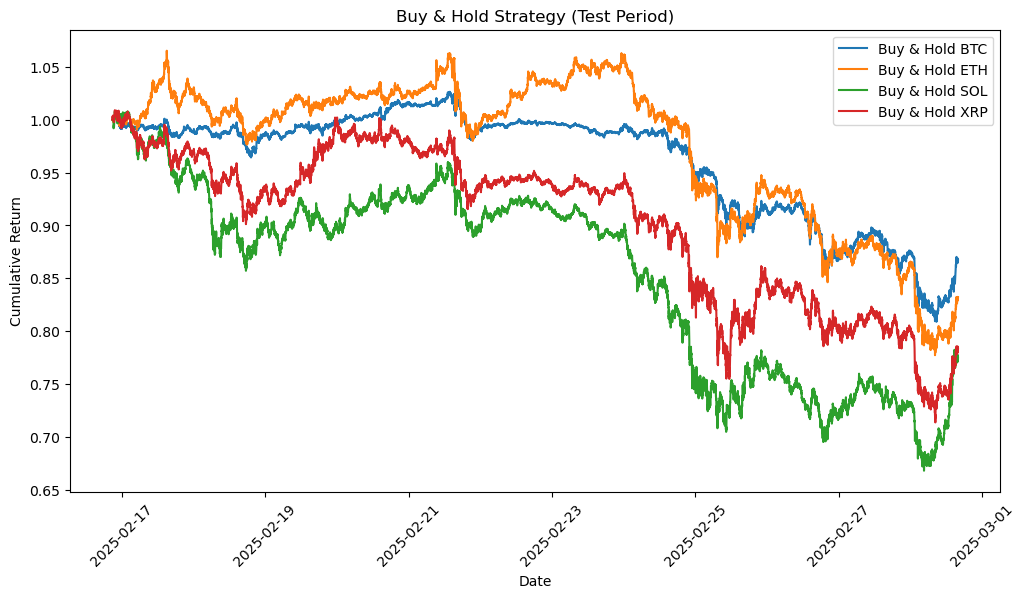

In [11]:
# Reload the dataset
file_path = "./data_with_indicators/crypto_prices_1m_with_indicators.csv"
df, feature_cols = load_and_preprocess_data(file_path)

# Function to plot Buy & Hold strategy for the test period (last 20% of the dataset)
def plot_buy_and_hold_test_period(df):
    plt.figure(figsize=(12, 6))

    for coin in df['Coin'].unique():
        df_coin = df[df['Coin'] == coin].sort_values('Datetime')

        # Split data (80% train, 20% test)
        split_index = int(len(df_coin) * 0.8)
        df_test = df_coin.iloc[split_index:]  # Select last 20%

        if df_test.empty:
            continue  # Skip if no test data

        initial_price = df_test['Close'].iloc[0]
        buy_and_hold_returns = df_test['Close'] / initial_price  # Normalize returns

        plt.plot(df_test['Datetime'], buy_and_hold_returns, label=f'Buy & Hold {coin}')

    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Buy & Hold Strategy (Test Period)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# Plot the Buy & Hold strategy for the test period
plot_buy_and_hold_test_period(df) 

In [12]:
# Function to calculate returns for both strategies during the test period
def calculate_strategy_returns(df, all_trades_df):
    results = []

    for coin in df['Coin'].unique():
        df_coin = df[df['Coin'] == coin].sort_values('Datetime')

        # Split data (80% train, 20% test)
        split_index = int(len(df_coin) * 0.8)
        df_test = df_coin.iloc[split_index:]  # Select last 20%

        if df_test.empty:
            continue  # Skip if no test data

        # Buy & Hold Strategy Return
        initial_price = df_test['Close'].iloc[0]
        final_price = df_test['Close'].iloc[-1]
        buy_and_hold_return = (final_price / initial_price) - 1

        # Trading Strategy Return (from the logged trades)
        df_trades = all_trades_df[all_trades_df['Coin'] == coin]
        strategy_return = df_trades['Cumulative_Return'].iloc[-1] if not df_trades.empty else None

        results.append({
            "Coin": coin,
            "Buy & Hold Return (%)": round(buy_and_hold_return * 100, 2),
            "Trading Strategy Return (%)": round(strategy_return * 100, 2) if strategy_return is not None else None
        })

    return pd.DataFrame(results)

# Check if trading results exist
if 'all_trades_df' in globals():
    strategy_returns_df = calculate_strategy_returns(df, all_trades_df)
    print(strategy_returns_df)
else:
    print("Trading strategy results are missing. Please re-run the trading model first.")




  Coin  Buy & Hold Return (%)  Trading Strategy Return (%)
0  BTC                 -13.29                        25.40
1  ETH                 -16.81                         9.22
2  SOL                 -22.53                         8.89
3  XRP                 -21.68                       -18.71
